In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt
from datasets import AgeRGB

In [8]:
args = {}
args["data_dir"] = "data/XPAge01_RGB"
args["data"] = "age"
args["lr"] = 0.003
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [9]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [14]:
import timm
import torch.nn.functional as F

class WarmUpResNet(nn.Module):
    def __init__(
        self, backbone="resnet18"
    ):
        super(WarmUpResNet, self).__init__()
        self.backbone = timm.create_model('resnet18', pretrained=True, num_classes=256)
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [15]:
device = utils.get_device("mps")
model = WarmUpResNet()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [16]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [17]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 224, 224]) torch.Size([4])


In [18]:
from tqdm import tqdm
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs.repeat(1,3,1,1))
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 20)

Train Epoch 1/20:   0%|          | 0/18 [00:00<?, ?batch/s]/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Val Epoch 1/20: 100%|██████████| 2/2 [00:11<00:00,  5.99s/batch]


Epoch 1/20 -> Train Loss: 343.0114, Val Loss: 405.0729


Val Epoch 2/20: 100%|██████████| 2/2 [00:11<00:00,  5.97s/batch]


Epoch 2/20 -> Train Loss: 91.0202, Val Loss: 50.5255


Val Epoch 3/20: 100%|██████████| 2/2 [00:11<00:00,  5.93s/batch]


Epoch 3/20 -> Train Loss: 82.1198, Val Loss: 48.0020


Val Epoch 4/20: 100%|██████████| 2/2 [00:11<00:00,  5.93s/batch]


Epoch 4/20 -> Train Loss: 81.0064, Val Loss: 54.8752


Val Epoch 5/20: 100%|██████████| 2/2 [20:42<00:00, 621.01s/batch]


Epoch 5/20 -> Train Loss: 74.9109, Val Loss: 62.2386


Val Epoch 6/20: 100%|██████████| 2/2 [00:14<00:00,  7.41s/batch]


Epoch 6/20 -> Train Loss: 72.7790, Val Loss: 162.9670


Val Epoch 7/20: 100%|██████████| 2/2 [16:57<00:00, 508.54s/batch]


Epoch 7/20 -> Train Loss: 90.5443, Val Loss: 48.3319


Val Epoch 8/20: 100%|██████████| 2/2 [35:29<00:00, 1064.73s/batch]


Epoch 8/20 -> Train Loss: 76.8370, Val Loss: 43.2343


Val Epoch 9/20: 100%|██████████| 2/2 [00:12<00:00,  6.01s/batch]


Epoch 9/20 -> Train Loss: 72.6080, Val Loss: 41.4752


Val Epoch 10/20: 100%|██████████| 2/2 [00:12<00:00,  6.25s/batch]


Epoch 10/20 -> Train Loss: 70.3742, Val Loss: 54.6968


Val Epoch 11/20: 100%|██████████| 2/2 [00:12<00:00,  6.09s/batch]


Epoch 11/20 -> Train Loss: 72.9694, Val Loss: 44.2781


Val Epoch 12/20: 100%|██████████| 2/2 [00:11<00:00,  5.99s/batch]


Epoch 12/20 -> Train Loss: 71.9195, Val Loss: 43.5158


Val Epoch 13/20: 100%|██████████| 2/2 [00:11<00:00,  5.97s/batch]


Epoch 13/20 -> Train Loss: 78.5072, Val Loss: 44.3175


Val Epoch 14/20: 100%|██████████| 2/2 [00:12<00:00,  6.03s/batch]


Epoch 14/20 -> Train Loss: 83.3578, Val Loss: 48.2116


Val Epoch 15/20: 100%|██████████| 2/2 [00:12<00:00,  6.08s/batch]


Epoch 15/20 -> Train Loss: 69.2589, Val Loss: 53.1371


Val Epoch 16/20: 100%|██████████| 2/2 [00:12<00:00,  6.17s/batch]


Epoch 16/20 -> Train Loss: 67.9500, Val Loss: 47.7862


Val Epoch 17/20: 100%|██████████| 2/2 [00:12<00:00,  6.02s/batch]


Epoch 17/20 -> Train Loss: 62.5643, Val Loss: 44.7393


Val Epoch 18/20: 100%|██████████| 2/2 [00:11<00:00,  6.00s/batch]


Epoch 18/20 -> Train Loss: 76.6175, Val Loss: 98.4930


Val Epoch 19/20: 100%|██████████| 2/2 [00:11<00:00,  5.99s/batch]


Epoch 19/20 -> Train Loss: 95.0278, Val Loss: 64.6912


Val Epoch 20/20: 100%|██████████| 2/2 [00:12<00:00,  6.05s/batch]

Epoch 20/20 -> Train Loss: 60.0439, Val Loss: 41.8259


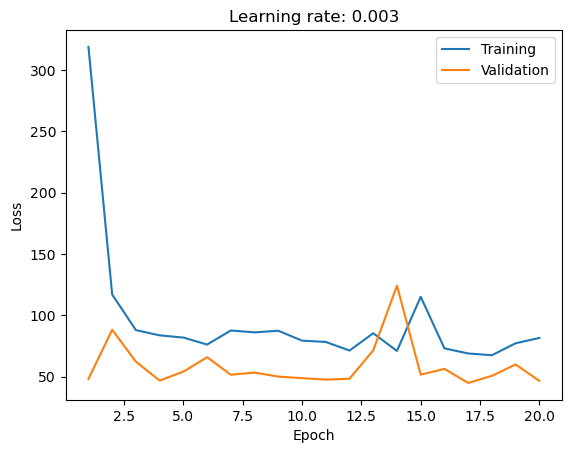

In [25]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [26]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [27]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1,3,1,1))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 57.5466


In [28]:
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(targets, outputs))

MAE: 12.328134


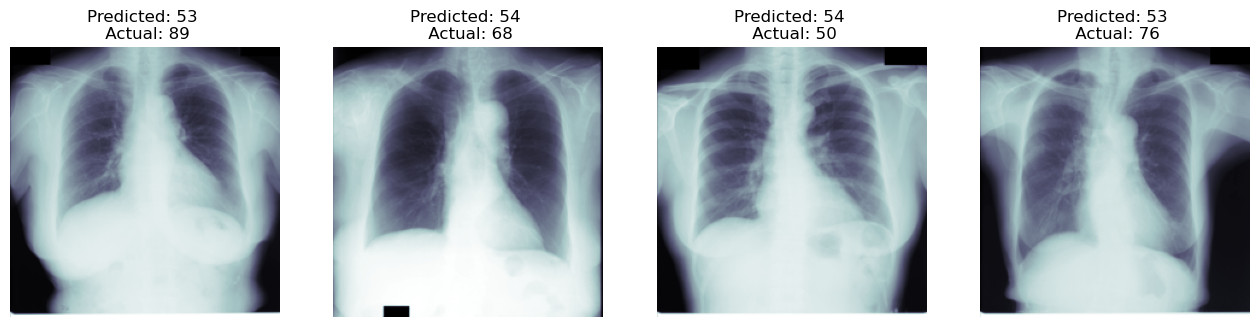

In [29]:
fig = plt.figure(figsize=(16,4))
fig.add_subplot(141)
plt.imshow(image_to_arrag(inputs[0]), cmap=plt.cm.bone)
plt.title(f"Predicted: {round(outputs[0].item())} \n Actual: {round(targets[0].item())}")
plt.axis("off")
fig.add_subplot(142)
plt.imshow(image_to_arrag(inputs[1]), cmap=plt.cm.bone)
plt.title(f"Predicted: {round(outputs[1].item())} \n Actual: {round(targets[1].item())}")
plt.axis("off")
fig.add_subplot(143)
plt.imshow(image_to_arrag(inputs[2]), cmap=plt.cm.bone)
plt.title(f"Predicted: {round(outputs[2].item())} \n Actual: {round(targets[2].item())}")
plt.axis("off")
fig.add_subplot(144)
plt.imshow(image_to_arrag(inputs[12]), cmap=plt.cm.bone)
plt.title(f"Predicted: {round(outputs[12].item())} \n Actual: {round(targets[12].item())}")
plt.axis("off")
plt.show()